# Climate sensitivity and feedback

## source
This notebook is adapted from the [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

____________

## 1. Radiative forcing
____________

### The concept

We've seen the concept of Radiative Forcing before. It is the short-term change in the TOA (actually the tropopause, which will see is quite different!) energy budget when we add a forcing agent to the climate system, **before the surface has a chance to warm up**.

The standard reference forcing is a **doubling of atmospheric CO$_2$**. 

The **radiative forcing** is a number in W m$^{-2}$, defined so that it is **positive if the system is gaining energy**:

$$ \Delta R = \left(\text{ASR}_{2xCO2} - \text{OLR}_{2xCO2}\right) - \left(\text{ASR}_{ref} - \text{OLR}_{ref}\right)$$

$\Delta R$ is a measure of the rate at which energy begins to accumulate in the climate system after an abrupt increase in greenhouse gases, but *before any change in climate* (i.e. temperature).

### Setting up a single-column Radiative-Convective model

Let's set up a single-column Radiative-Convective model and look carefully at what happens when we add extra CO$_2$ to the column.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT
import climlab

/Users/tompkins/Library/Python/3.10/lib/python/site-packages/climlab/radiation/cam3.py:46: UserWarning: Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.')
/Users/tompkins/Library/Python/3.10/lib/python/site-packages/climlab/radiation/rrtm/rrtmg_lw.py:19: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.')
/Users/tompkins/Library/Python/3.10/lib/python/site-packages/climlab/radiation/rrtm/rrtmg_sw.py:19: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_SW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_SW module will not be functional.')
/Users/tompkins/Library/Python/3.10/lib

In [2]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)
#  Take global, annual average 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

#  Resuable function to plot the temperature data on a Skew-T chart
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

#  and a function to add extra profiles to this chart
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

# Get the water vapor data from CESM output
#cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"

#ncep_air = xr.open_dataset("~/Downloads/air.mon.1981-2010.ltm.nc", use_cftime=True)
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))

NameError: name 'cesm_data_path' is not defined

In [48]:
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Build the radiation model -- just like we already did
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=mystate, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )
#  Now create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,
                                              )
#  Here is where we build the model by coupling together the two components
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

In [49]:
print(rcm)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
Radiative-Convective Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



First let's take a look at the default CO$_2$ amount in our reference model:

In [50]:
rcm.subprocess['Radiation'].absorber_vmr['CO2']

0.000348

That's 348 parts per million (ppm). Our atmosphere was at this level around the late 1980s.

Before we can look at the effects of a CO2 perturbation we need to integrate our reference model out to equilibrium:

In [51]:
rcm.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 4.999422301147019 years.


Are we close to energy balance?

In [52]:
rcm.ASR - rcm.OLR

Field([-3.36228823e-11])

### A perturbed CO2 calculation in the RCM

In [53]:
# Make an exact clone with same temperatures
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.name = 'Radiative-Convective Model (2xCO2 initial)'

In [54]:
#  Check to see that we indeed have the same CO2 amount
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

0.000348

In [55]:
#  Now double it!
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2

In [56]:
#  and verify
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

0.000696

### Calculate instantaneous radiative forcing

The simplest measure of radiative forcing is **the instantaneous change** in the energy budget **before the temperature have a chance to adjust**.

To get this we need to call the `compute_diagnostics` method, but not any forward timestep.

In [57]:
rcm_2xCO2.compute_diagnostics()

Now take a look at the changes in the SW and LW budgets:

In [58]:
rcm_2xCO2.ASR - rcm.ASR

Field([0.06274162])

In [59]:
rcm_2xCO2.OLR - rcm.OLR

Field([-2.11458541])

So what is instantaneous radiative forcing for the doubling of CO2?

In [15]:
DeltaR_instant = (rcm_2xCO2.ASR - rcm_2xCO2.OLR) - (rcm.ASR - rcm.OLR)
DeltaR_instant

Field([2.17732704])

The radiative forcing for a doubling of CO2 in this model is 2.18 W m$^{-2}$.

As we can see above, almost all of the radiative forcing appears in the longwave. We have made the atmosphere **more optically thick** by adding CO$_2$.

Think about this the same way we increased the absorptivity / emissivity parameter $\epsilon$ in the simple grey-gas model.

### Statosphere-adjusted radiative forcing

The point of measuring radiative forcing is that it should give us some information about how much global warming we should expect from a particular forcing agent.

We will need to use our model to quantify the **eventual** temperature change associated with this forcing.

A more useful measure of the global warming impact of a forcing agent comes from thinking about **changes in radiative flux at the tropopause** rather than the Top of Atmosphere.

The idea here is that we will **let the stratosphere adjust to the extra CO$_2$** while **holding the troposphere and surface temperatures fixed**.  

Discuss in class why the stratospheric adjustment is more appropriate in your opinion?


In this model levels 0 through 12 are in the statosphere; levels 13 and larger are in the troposphere:

In [62]:
rcm.lev[12:]

array([192.539935, 226.513265, 266.481155, 313.501265, 368.81798 ,
       433.895225, 510.455255, 600.5242  , 696.79629 , 787.70206 ,
       867.16076 , 929.648875, 970.55483 , 992.5561  ])

So to compute stratosphere-adjusted forcing, we'll timestep the model, but continually reset the temperatures to their reference values below 226 hPa:

In [67]:
rcm_2xCO2_strat = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_strat.name = 'Radiative-Convective Model (2xCO2 stratosphere-adjusted)'
for n in range(1000):
    rcm_2xCO2_strat.step_forward()
    # hold tropospheric and surface temperatures fixed
    rcm_2xCO2_strat.Tatm[9:] = rcm.Tatm[9:]
    rcm_2xCO2_strat.Ts[:] = rcm.Ts[:]

Now we can compute the stratosphere-adjusted radiative forcing for the doubling of CO2:

In [68]:
DeltaR = (rcm_2xCO2_strat.ASR - rcm_2xCO2_strat.OLR) - (rcm.ASR - rcm.OLR)
DeltaR

Field([4.24788561])

The result is about 4.2 W m$^{-2}$.  This ia actually now very close to the value quoted in class of around 4 W m$^{-2}$.

____________

<a id='section2'></a>

## 2. Equilibrium climate sensitivity (without feedback)
____________

We now ask the question: How much warming will we get (eventually) in response to this positive radiative forcing?

### Definition

We define the **Equilibrium Climate Sensitivity** (denoted **ECS** or $\Delta T_{2xCO2}$):

*The global mean surface warming necessary to balance the planetary energy budget after a doubling of atmospheric CO$_2$.*

### Climate change in the single-column RCM

We can go ahead and calculate ECS in our single-column model:

In [69]:
rcm_2xCO2_eq = climlab.process_like(rcm_2xCO2_strat)
rcm_2xCO2_eq.name = 'Radiative-Convective Model (2xCO2 equilibrium)'
rcm_2xCO2_eq.integrate_years(5)

Integrating for 1826 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 12.736753858124827 years.


In [70]:
# are we close to equilibrium?
rcm_2xCO2_eq.ASR - rcm_2xCO2_eq.OLR

Field([1.30171429e-11])

Let's follow what we have done before and plot the results on a nice Skew-T:

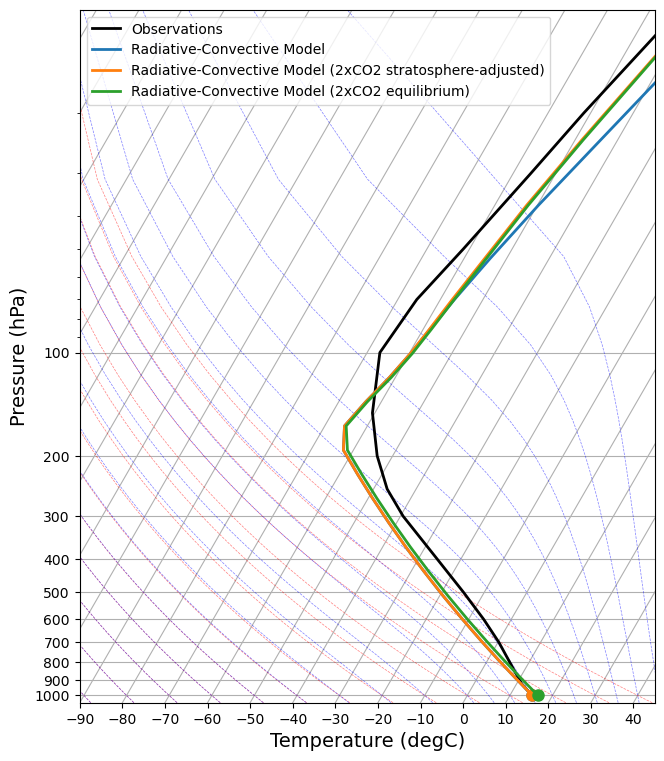

In [71]:
skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_strat)
add_profile(skew, rcm_2xCO2_eq)

### Questions:

- In the troposphere, where is the blue line? Is it hidden by the orange or the green?

- What do you see here? What has changed?

### Calculate the ECS

It is just the difference in surface temperature:

In [73]:
ECS_nofeedback = rcm_2xCO2_eq.Ts - rcm.Ts
ECS_nofeedback

Field([1.29984831])

Doubling CO$_2$ in this model causes about 1.3 K of warming at equilibrium.

What processes has this model included?

- Radiation heating/cooling
- Convective heating
- The model would be able to account for the lapse rate feedback, but currently the adjustment scheme uses a fixed lapse rate. 

What processes are missing from the model?

- Water vapor (the convective adjustment scheme used here is very simple and does not adjust water vapor, unlike the more comprehensive adjustment scheme of Betts-Miller, or alternative mass flux scheme approaches that we discussed in class)
- Clouds (which are set to zero here).
- All slower processes (no vegetation, no ice feedback, no carbon cycle, no aerosols...)



So what about the energy budget? 

Remember that we have let the model warm up to its new equilibrium! 

If we look at the differences between the two equilibrium states (before and after doubling CO$_2$), we find only very small and offsetting changes in SW and LW:

In [74]:
rcm_2xCO2_eq.OLR - rcm.OLR

Field([0.05080282])

In [75]:
rcm_2xCO2_eq.ASR - rcm.ASR

Field([0.05080282])

The 1.3 K sensitivity we've just calculated is the warming that we would have *if there were no other changes (feedbacks) in response to the CO$_2$ induced warming!* Because the model has all otehr feedbacks switched off. 

### The no-feedback response

We have just calculated an equilibrium warming $\Delta T_0$ (in K) resulting from a radiative forcing $\Delta R$ (in W m$^{-2}$) for a model without feedback.

Let's define the **no-feedback climate response parameter** $\lambda_0$ as

$$ \lambda_0 = -\frac{\Delta R}{\Delta T_0 } $$

With the numbers we came up with above,

In [76]:
lambda0 = -DeltaR / ECS_nofeedback
lambda0

Field([-3.26798564])

The no-feedback climate response parameter is $\lambda_0 = -3.3$ W m$^{-2}$ K$^{-1}$.

This What are some important processes that our model has neglected?  

____________
## 3. Water vapor feedback in the radiative-convective model
____________

In nature, as in a complex GCM, water vapor tends to increase as the air temperature warms.

The main reason for this is that **the saturation specific humidity** (i.e. how much water vapor the air can hold) **increases strongly with temperature**.  We saw in the earlier lectures that Clausius Clapeyron gives us a scaling 

$$ \frac{dq_v}{q_v}\approx 20 \frac{dT}{T}$$

which equates to approximately a 7\% increase per degree of warming, roughly.  We stated in class that models calculate the feedback of water vapor to be roughly 2 W m$^{-2}$ K$^{-1}$.  Here we will attempt to calculate this in the column model.  We will do this by making the assumption that **relative humidity remain fixed** as the column warms, which global climate models reveal to be a reasonable zero order assumption. 

In [77]:
#  actual specific humidity
q = rcm.subprocess['Radiation'].specific_humidity
#  saturation specific humidity (a function of temperature and pressure)
qsat = climlab.utils.thermo.qsat(rcm.Tatm, rcm.lev)
#  Relative humidity
rh = q/qsat

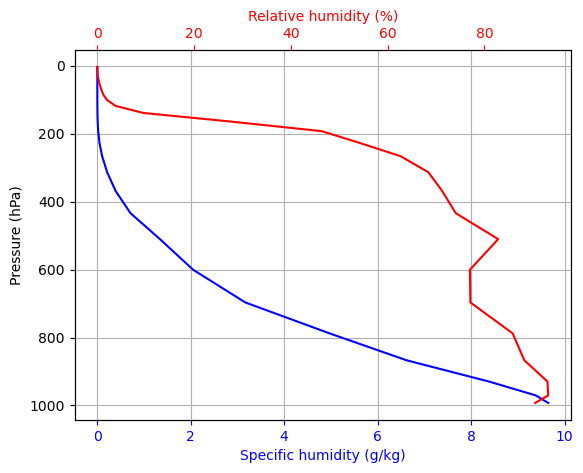

In [78]:
#  Plot relative humidity in percent
fig,ax = plt.subplots()
ax.plot(q*1000, rcm.lev, 'b-')
ax.invert_yaxis()
ax.grid()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)', color='b')
ax.tick_params('x', colors='b')
ax2 = ax.twiny()
ax2.plot(rh*100., rcm.lev, 'r-')
ax2.set_xlabel('Relative humidity (%)', color='r')
ax2.tick_params('x', colors='r')

###  A radiative-convective model with fixed relative humidity

In [79]:
rcm_2xCO2_h2o = climlab.process_like(rcm_2xCO2)
rcm_2xCO2_h2o.name = 'Radiative-Convective Model (2xCO2 equilibrium with H2O feedback)'

In [80]:
for n in range(2000):
    # At every timestep
    # we calculate the new saturation specific humidity for the new temperature
    #  and change the water vapor in the radiation model
    #  so that relative humidity is always the same
    qsat = climlab.utils.thermo.qsat(rcm_2xCO2_h2o.Tatm, rcm_2xCO2_h2o.lev)
    rcm_2xCO2_h2o.subprocess['Radiation'].specific_humidity[:] = rh * qsat
    rcm_2xCO2_h2o.step_forward()

In [81]:
# Check for energy balance
rcm_2xCO2_h2o.ASR - rcm_2xCO2_h2o.OLR

Field([-1.7317933e-07])

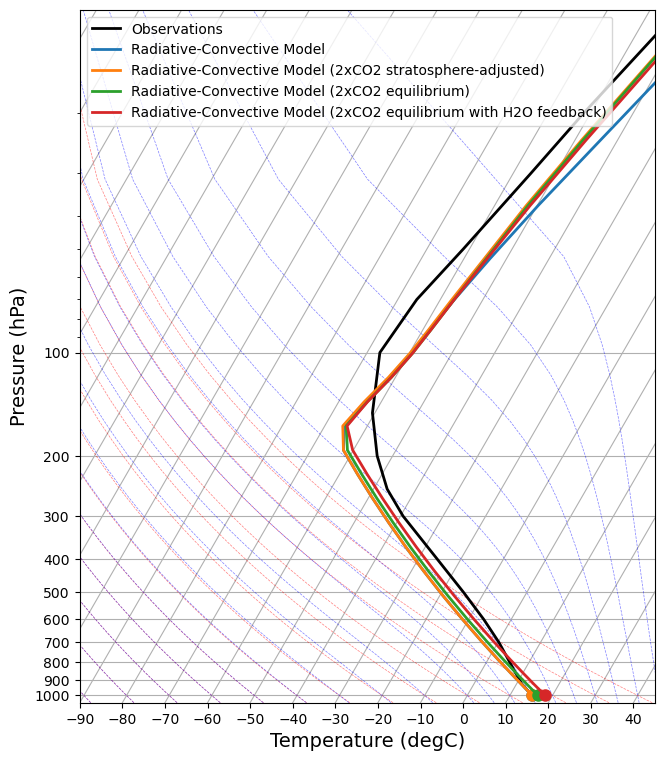

In [40]:
skew = make_skewT()
add_profile(skew, rcm)
add_profile(skew, rcm_2xCO2_strat)
add_profile(skew, rcm_2xCO2_eq)
add_profile(skew, rcm_2xCO2_h2o)

What is the Equilibrium Climate Sensitivity of this new model?

In [82]:
ECS = rcm_2xCO2_h2o.Ts - rcm.Ts
ECS

Field([2.98902357])

With the water vapor feedback, doubling CO$_2$ causes 3 K of warming at equilibrium, rather than the no-feedback sensitivity of 1.3 K.

A pretty big difference!

The system gain is the ratio

In [42]:
g = ECS / ECS_nofeedback
g

Field([2.29951722])

So the moistening of the atmosphere more than doubles the global warming effect.

____________
<a id='section6'></a>
## 4. Contribution of individual feedback processes to Equilibrium Climate Sensitivity
____________

### Adding up the effects of different feedbacks

If you recall, we can think of individual feedback amounts ${\lambda}_1, {\lambda}_2, ...$, with each  representing a physically distinct mechanism, e.g. water vapor, surface snow and ice, cloud changes, lapse rate effects, etc. and we made the assumption that they are linear and unrelated with each other, so that we could simply add them up to get the total feedback. 

The feedback amounts were additive (non-interacting),

$$ \lambda = {\lambda}_0 + {\lambda}_1 + {\lambda}_2 + ... = \sum_{i=0}^N {\lambda}_i $$

### Climate feedback parameters

We wrote this in terms of the original radiative forcing as	

$$ \Delta T_{2xCO2} = \frac{-\Delta R}{\lambda_0 + \sum_{i=1}^{N} \lambda_i} $$


known as **climate feedback parameters**, in units of W m$^{-2}$ K$^{-1}$. 

With this choice of sign conventions, $\lambda_i > 0$ for a positive feedback process.

Individual feedback parameters $\lambda_i$ are then additive, and can be compared to the no-feedback, black body
parameter $\lambda_0$.

We might decompose the net climate feedback into, for example

- longwave and shortwave processes
- cloud and non-cloud processes

These individual feedback processes may be positive or negative. This is very powerful, because we can **measure the relative importance of different feedback processes** simply by comparing their $\lambda_i$ values.

### Every climate model has a Planck feedback

Our no-feedback response parameter $\lambda_0$ is often called the **Planck feedback**.

It is not really a feedback at all.  It is the most basic and universal climate process, and is present in every climate model. It is simply an expression of the fact that a warm planet radiates more to space than a cold planet.

As we will see, our estimate of $\lambda_0 = -3.3 ~\text{W} ~\text{m}^{-2} ~\text{K}^{-1} $ is essentially the same as the Planck feedback diagnosed from complex GCMs. 

### Calculate the feedback parameters in our single-column model

We can easily calculate the feedback parameter in our model with water vapor feedback.

This is just the ratio of the radiative forcing $\Delta R$ to the climate sensitivity:

In [83]:
lambda_net = -DeltaR / ECS
lambda_net

Field([-1.42116163])

The net feedback is $\lambda = -1.43$ W m$^{-2}$ K$^{-1}$.

Because of the additive nature of the feedbacks, this means that the individual contribution of the water vapor feedback is

$$ \lambda_{h2o} = \lambda - \lambda_0 $$

In [84]:
lambda_h2o = lambda_net - lambda0
lambda_h2o

Field([1.84682401])

So we measure a water vapor feedback of $\lambda_{h2o} = 1.85$ W m$^{-2}$ K$^{-1}$.

This is a **positive number** consistent with the **amplifying effect** of the water vapor feedback.

The physical meaning of this number:

**For every 1 degree of surface warming, the increased water vapor greenhouse effect provides an additional 1.86 W m$^{-2}$ of radiative forcing.**

Things to note:

- The models all agree strongly on the Planck feedback. 
- The Planck feedback is about $-3.3 ~\text{W} ~\text{m}^{-2} ~\text{K}^{-1} $ just like our above estimate of $\lambda_0$ (but with opposite sign convention -- watch carefully for that in the literature)
- The water vapor feedback is strongly positive in every model.
- The lapse rate feedback is something we will study later. It is slightly negative.
- For reasons we will discuss later, the best way to measure the water vapor feedback is to combine it with lapse rate feedback.
- Models agree strongly on the combined water vapor plus lapse rate feedback.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________